# Final Accuracies and Predictions

#### Loading Datasets

In [6]:
from custom_dataset_loader import CustomCocoManualDataset
import torchvision.transforms as T


In [7]:

#Initializing Train Dataset
train_dataset = CustomCocoManualDataset(
    root='../../dataset/prod/yolo_dataset/train/images', 
    annFile='../../dataset/prod/yolo_dataset/train/annotations/coco_annotation.json',
    transforms=T.ToTensor()  
)

#Initializing Validation Dataset
valid_dataset = CustomCocoManualDataset(
    root='../../dataset/prod/yolo_dataset/valid/images', 
    annFile='../../dataset/prod/yolo_dataset/valid/annotations/coco_annotation.json', 
    transforms=T.ToTensor() 
)

#Initializing Test Dataset
test_dataset = CustomCocoManualDataset(
    root='../../dataset/prod/yolo_dataset/test/images', 
    annFile='../../dataset/prod/yolo_dataset/test/annotations/coco_annotation.json',
    transforms=T.ToTensor()  
)


loading annotations into memory...
Done (t=0.49s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


#### Loading Model (15 Ep)

In [8]:
checkpoint_path = "../../checkpoints/mask_rcnn_epoch_15.pth"

In [9]:
import torch 
import torchvision

model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False)
num_classes = 7  #same class range as trained model
in_features = model.roi_heads.box_predictor.cls_score.in_features

#replacing head
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

#replacing mask header
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = torchvision.models.detection.mask_rcnn.MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

checkpoint = torch.load(checkpoint_path)
checkpoint_filtered = {k: v for k, v in checkpoint.items() if not k.startswith('roi_heads.mask_predictor.mask_fcn_logits')}

model.load_state_dict(checkpoint_filtered, strict=False)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

model.eval()

print("Model loaded successfully with trained backbone and heads re-initialized for the correct number of classes")

Model loaded successfully with trained backbone and heads re-initialized for the correct number of classes


#### Prediction vs Actual Detection Performance

In [10]:

#loading the labels
def load_labels(label_file):
    with open(label_file, 'r') as f:
        labels = [line.strip() for line in f.readlines()]
    return labels

label_file = "../../labels.txt"
labels = load_labels(label_file)

In [11]:
from PIL import Image 
import torchvision.transforms as T

import torchvision.ops as ops
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

In [12]:
img_path = "../../dataset/prod/yolo_dataset/train/resized_images/01F3MMVAVT1Z7Z6RNST2XYWXHM_jpeg_jpg.rf.50f281a3b86c7c59402ae3ca0ab10521.jpg"  # Replace with the path to your test image
image = Image.open(img_path)

#converting to a tensor 
transform = T.ToTensor()
image_tensor = transform(image).unsqueeze(0).to(device)

root_dir = '../../dataset/prod/yolo_dataset/train/images'
ann_file = '../../dataset/prod/yolo_dataset/train/annotations/coco_annotation.json'

img_path = "../../dataset/prod/yolo_dataset/train/images/01F3MMVAVT1Z7Z6RNST2XYWXHM_jpeg_jpg.rf.50f281a3b86c7c59402ae3ca0ab10521.jpg"  # Replace with your image path
image = Image.open(img_path).convert("RGB")

coco = COCO(ann_file)


loading annotations into memory...
Done (t=0.53s)
creating index...
index created!


Image ID: 15


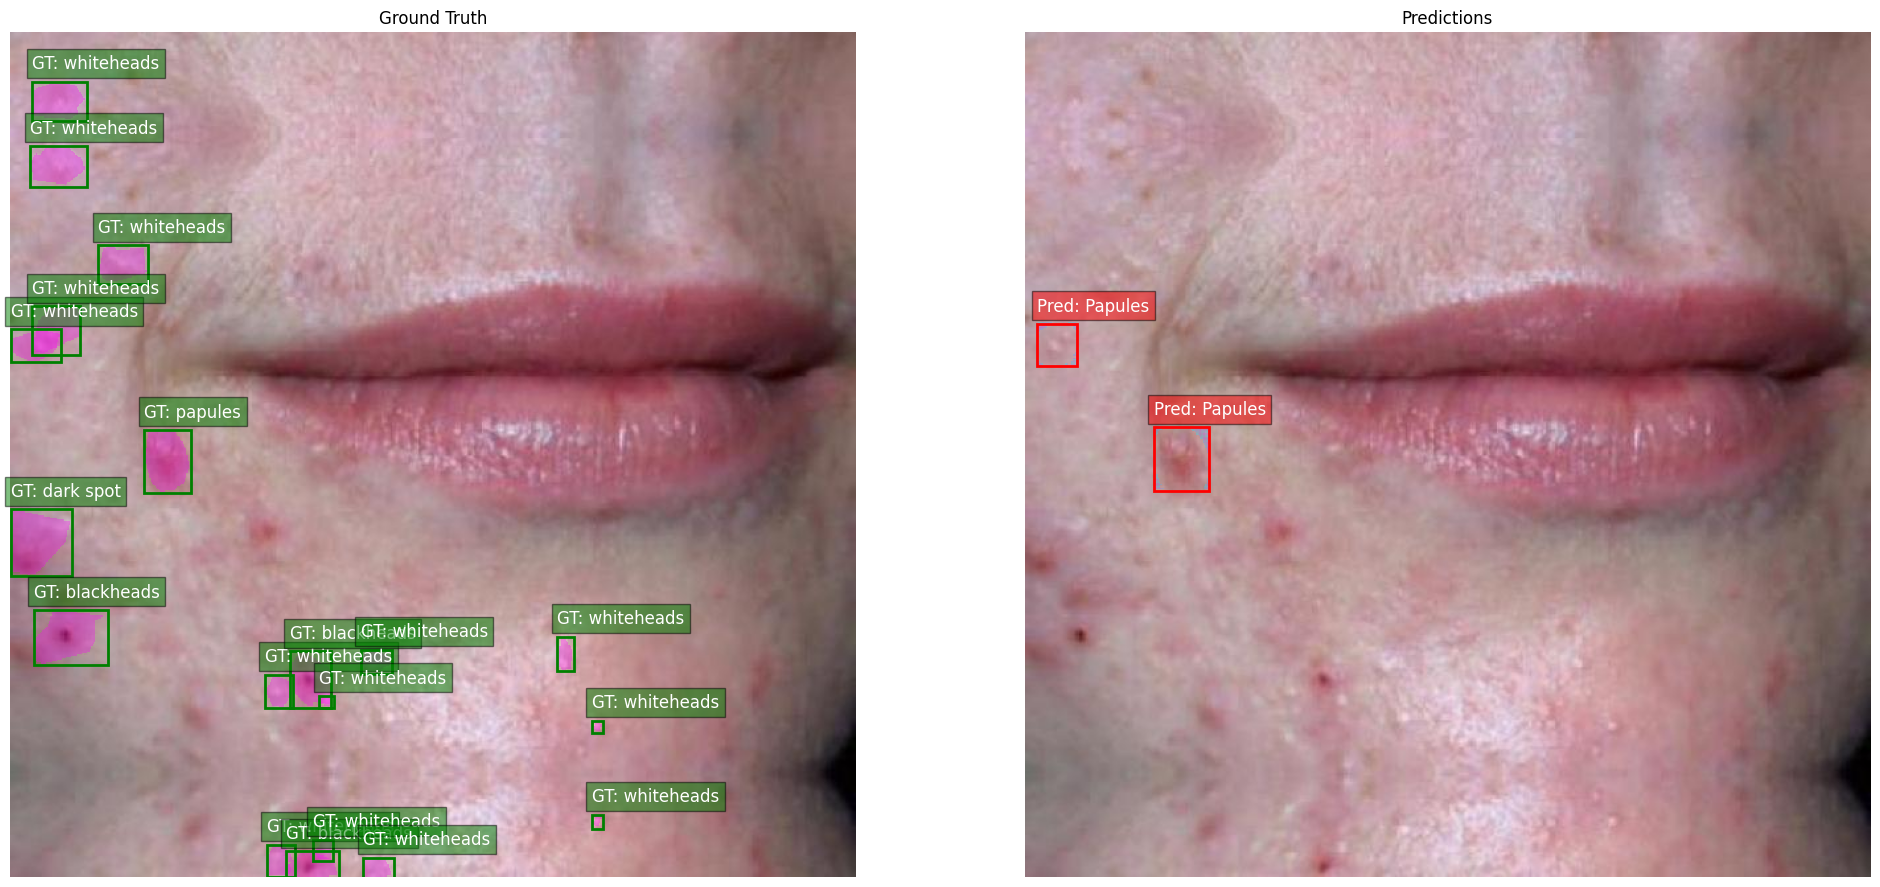

In [13]:

# Get the list of all image IDs from the COCO dataset
img_ids = coco.getImgIds()

# Find the correct image ID by matching the filename in the annotations
img_info = None
for img_id in img_ids:
    info = coco.loadImgs(img_id)[0]
    if info['file_name'] == img_path.split('/')[-1]:
        img_info = info
        break

if img_info is None:
    raise ValueError(f"Image {img_path} not found in the annotations.")

# Now use the correct img_id
img_id = img_info['id']
print(f"Image ID: {img_id}")	

# Load annotations for the image
ann_ids = coco.getAnnIds(imgIds=img_id)
anns = coco.loadAnns(ann_ids)

# Transform the image for the model
transform = T.ToTensor()  # Only apply ToTensor for testing
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
image_tensor = image_tensor.to(device)  # Move to GPU if available

# Disable gradient calculations and run inference
with torch.no_grad():
    predictions = model(image_tensor)

# Extract bounding boxes, labels, and masks from predictions
pred_boxes = predictions[0]['boxes']  # Bounding boxes
pred_labels = predictions[0]['labels']  # Class labels
pred_scores = predictions[0]['scores']  # Confidence scores
pred_masks = predictions[0]['masks'].cpu().numpy()  # Segmentation masks

# Apply Non-Maximum Suppression (NMS)
iou_threshold = 0.05  # IoU threshold for NMS
keep = ops.nms(pred_boxes, pred_scores, iou_threshold)

# Filter out the predictions using the NMS result
pred_boxes = pred_boxes[keep].cpu().numpy()  # Move boxes to CPU and convert to NumPy
pred_labels = pred_labels[keep].cpu().numpy()  # Move labels to CPU and convert to NumPy
pred_scores = pred_scores[keep].cpu().numpy()  # Move scores to CPU and convert to NumPy

# Make sure to move the masks to the CPU and then index it
pred_masks = predictions[0]['masks'][keep].cpu().numpy()  # Move masks to CPU and then convert to NumPy

# Filter out low-confidence predictions (if necessary after NMS)
score_threshold = 0.4
pred_boxes = pred_boxes[pred_scores > score_threshold]
pred_labels = pred_labels[pred_scores > score_threshold]
pred_masks = pred_masks[pred_scores > score_threshold]


# Create two separate plots: one for ground truth and one for predictions
fig, axes = plt.subplots(1, 2, figsize=(24, 12))

# Plot ground truth on the left
ax_gt = axes[0]
ax_gt.imshow(image)

# Plot ground truth (Green for ground truth)
for ann in anns:
    # Get bounding box
    x_min, y_min, width, height = ann['bbox']
    x_max, y_max = x_min + width, y_min + height
    rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='g', facecolor='none')
    ax_gt.add_patch(rect)

    # Get class label
    class_name = coco.loadCats(ann['category_id'])[0]['name']
    ax_gt.text(x_min, y_min - 10, f"GT: {class_name}", color='white', fontsize=12, bbox=dict(facecolor='green', alpha=0.5))

    # Optionally, plot segmentation mask for ground truth (if available)
    if 'segmentation' in ann:
        segm = ann['segmentation']
        mask = coco.annToMask(ann)
        ax_gt.imshow(np.ma.masked_where(mask < 0.5, mask), cmap="spring", alpha=0.3)  # Adjusted alpha for ground truth mask

ax_gt.set_title("Ground Truth")
ax_gt.axis('off')

# Plot predictions on the right
ax_pred = axes[1]
ax_pred.imshow(image)

# Plot predictions (Red for predictions)
for box, label, mask in zip(pred_boxes, pred_labels, pred_masks):
    class_name = labels[label]  # Get the class name from the label list
    x_min, y_min, x_max, y_max = box
    rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='r', facecolor='none')
    ax_pred.add_patch(rect)

    # Mask visualization
    mask = mask.squeeze()
    ax_pred.imshow(np.ma.masked_where(mask < 0.2, mask), cmap="cool", alpha=0.3)  # Adjusted alpha for predicted mask
    ax_pred.text(x_min, y_min - 10, f"Pred: {class_name}", color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

ax_pred.set_title("Predictions")
ax_pred.axis('off')

# Show the plot
plt.show()

## Accuracy of the Model

We have opted to choose the below metrics to evaluate the model's performance

1. Mean Intersection Over Union 
2. Average Precicion at IOU 0.5
3. Mean Average Precision (Sample)
4. F1 Score with Confusion Matrix 
5. ROC Curve 
6. AUC Curve at 0.5 IoC 
7. Mean Average Precision with various IoU Metrics
8. F2 Score
9. Miss Rate
10. Generalized IoU 

In [14]:
from sklearn.metrics import precision_recall_curve, confusion_matrix, classification_report, roc_curve, auc
from pycocotools.mask import iou
from torch.utils.data import DataLoader

##### IOU Calculation

In [15]:
def calculate_bbox_iou_single(box1, box2):

    x_min_inter = max(box1[0], box2[0])
    y_min_inter = max(box1[1], box2[1])
    x_max_inter = min(box1[2], box2[2])
    y_max_inter = min(box1[3], box2[3])

    inter_area = max(0, x_max_inter - x_min_inter) * max(0, y_max_inter - y_min_inter)

    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union_area = box1_area + box2_area - inter_area

    iou = inter_area / union_area if union_area != 0 else 0
    return iou

### 1. Average IOU 

In [16]:
def plot_iou_scores(iou_scores):
    
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(iou_scores) + 1), iou_scores, color='blue')
    plt.xlabel('Ground Truth Box Index')
    plt.ylabel('IoU Score')
    plt.title('IoU Scores for Ground Truth Bounding Boxes')
    plt.ylim([0, 1])  # IoU scores range from 0 to 1
    plt.xticks(range(1, len(iou_scores) + 1))
    plt.show()

In [17]:
def evaluate_single_image_iou_with_plot(model, image, target):

    model.eval()
    image = image.to(device)
    target = {k: v.to(device) for k, v in target.items()}

    with torch.no_grad():
        # Get model prediction for the single image
        output = model([image])[0]

        gt_boxes = target['boxes']  # Ground truth boxes
        pred_boxes = output['boxes']  # Predicted boxes

        iou_scores = []

        if len(gt_boxes) > 0 and len(pred_boxes) > 0:
            for i in range(len(gt_boxes)):
                best_iou = 0
                for j in range(len(pred_boxes)):
                    iou = calculate_bbox_iou_single(gt_boxes[i].cpu().numpy(), pred_boxes[j].cpu().numpy())
                    best_iou = max(best_iou, iou)
                iou_scores.append(best_iou)
                print(f"GT Box {i+1}: Best IoU = {best_iou:.4f}")
        else:
            print("No ground truth or predicted boxes found.")
            iou_scores.append(0)

    avg_iou = np.mean(iou_scores) if iou_scores else 0
    print(f"Average IoU for this image: {avg_iou:.4f}")

    # Plot IoU scores
    plot_iou_scores(iou_scores)

    return avg_iou


GT Box 1: Best IoU = 0.6688
GT Box 2: Best IoU = 0.0000
GT Box 3: Best IoU = 0.5225
GT Box 4: Best IoU = 0.0000
GT Box 5: Best IoU = 0.5874
GT Box 6: Best IoU = 0.5465
GT Box 7: Best IoU = 0.0000
Average IoU for this image: 0.3322


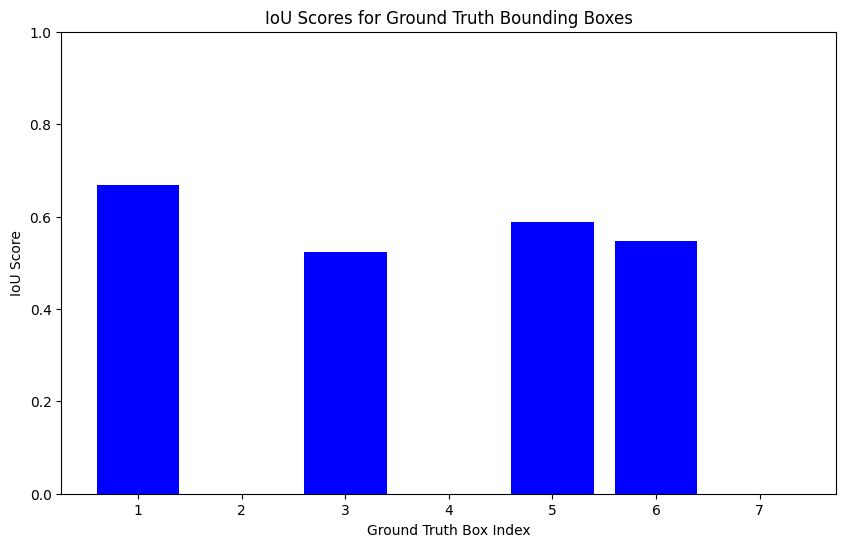

GT Box 1: Best IoU = 0.5372
GT Box 2: Best IoU = 0.0000
GT Box 3: Best IoU = 0.4861
GT Box 4: Best IoU = 0.6416
GT Box 5: Best IoU = 0.7160
GT Box 6: Best IoU = 0.3044
GT Box 7: Best IoU = 0.7790
GT Box 8: Best IoU = 0.7830
GT Box 9: Best IoU = 0.2580
GT Box 10: Best IoU = 0.2241
GT Box 11: Best IoU = 0.0187
GT Box 12: Best IoU = 0.3122
GT Box 13: Best IoU = 0.5980
GT Box 14: Best IoU = 0.2900
GT Box 15: Best IoU = 0.0000
GT Box 16: Best IoU = 0.1954
GT Box 17: Best IoU = 0.3181
GT Box 18: Best IoU = 0.5080
GT Box 19: Best IoU = 0.8432
GT Box 20: Best IoU = 0.3696
GT Box 21: Best IoU = 0.0000
Average IoU for this image: 0.3896


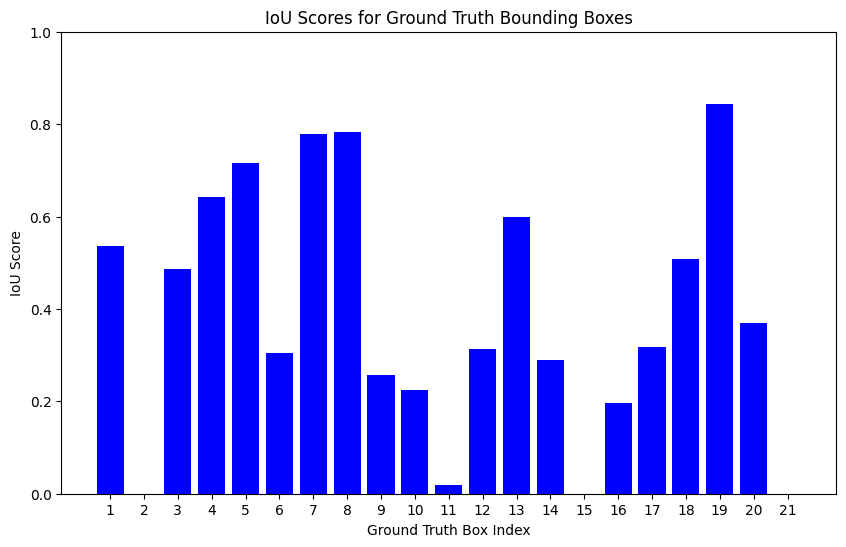

0.38964641954572427

In [18]:
image, target = train_dataset[11]
evaluate_single_image_iou_with_plot(model, image, target)

image, target = train_dataset[12]
evaluate_single_image_iou_with_plot(model, image, target)

With the sample values values, it deduce that the the average IOU stands at around 0.5 implying that the model performs well within 50% of the ground truth and predicted output overlapping. Having a less strict IOU value would provide better performance for the model as well. Therefore other evaluations will be mostly focused in the range of `0.30 to 0.70`

### 2. Sample Average Precision at IOU 0.5

Candidates for True Positives and False Positives.

`True Positives: if IoU exceeds threshold and ground truth is already not matches, It is deemed as True Positive`

`False Positives: If IoU does not exceed the threshold and does not meet the ground truth, It is deemed as False Positive`


#### Precision vs Recall

`Precision` is the ratio of true positives to the sum of true positives and false positives. It indicates how many of the predicted positives were actually correct

`Recall` is also known as true positive rate, is the ration of true postiives to the sum of true positives and false negatives. it shows how many of the actual posiives were correctly identified by the model

### Precision, Recall and F1 Calculation

#### Precision

Precision measures how many of the predicted bounding boxes are actually correct. It is given by:

$$
\text{Precision} = \frac{TP}{TP + FP}
$$

Where:
- \( TP \) are True Positives (correctly predicted objects).
- \( FP \) are False Positives (incorrectly predicted objects).

---

#### Recall

Recall measures how many of the actual objects were correctly predicted. It is given by:

$$
\text{Recall} = \frac{TP}{TP + FN}
$$

Where:
- \( TP \) are True Positives (correctly predicted objects).
- \( FN \) are False Negatives (objects that the model failed to predict).

---

##### Precision and Recall

In [19]:
def calculate_precision_recall(true_boxes, pred_boxes, pred_scores, iou_threshold=0.5):
    
    if len(pred_boxes) == 0:
        return 0,0
    
    #sort predicted boxes by their confidence scores 
    sorted_indices = np.argsort(-pred_scores)
    pred_boxes = pred_boxes[sorted_indices]
    pred_scores = pred_scores[sorted_indices]
    
    #match predictions to ground truth based on IoU threshold 
    
    tp = np.zeros(len(pred_boxes))
    fp = np.zeros(len(pred_boxes))
    
    detected_gt = []
    for i, pred_box in enumerate(pred_boxes):
            best_iou = 0
            best_gt_idx = -1
            for j, gt_box in enumerate(true_boxes):
                iou = calculate_bbox_iou_single(pred_box, gt_box)
                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = j

            # If IoU exceeds threshold and ground truth is not already matched
            
            if best_iou >= iou_threshold and best_gt_idx not in detected_gt:
                tp[i] = 1  # True positive
                detected_gt.append(best_gt_idx)  # Mark this ground truth as detected
            else:
                fp[i] = 1  # False positive
                
                # Calculate precision and recall
    tp_cumsum = np.cumsum(tp)
    fp_cumsum = np.cumsum(fp)
    precision = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-6)
    recall = tp_cumsum / len(true_boxes)

    return precision, recall
                
    

##### Average Precision Calculation

In [20]:
def calculate_ap(precision, recall):
    """Calculate average precision (AP) from precision and recall values."""
    recall = np.concatenate(([0.0], recall, [1.0]))
    precision = np.concatenate(([0.0], precision, [0.0]))

    for i in range(len(precision) - 1, 0, -1):
        precision[i - 1] = np.maximum(precision[i - 1], precision[i])

    recall_change = np.where(recall[1:] != recall[:-1])[0]
    ap = np.sum((recall[recall_change + 1] - recall[recall_change]) * precision[recall_change + 1])
    return ap

##### Evaluation

In [21]:
def plot_precision_recall(precision, recall):
    """Plot the precision-recall curve."""
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='o', label="Precision-Recall curve")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.grid(True)
    plt.show()

In [22]:
def evaluate_single_image_map(model, image, target, iou_threshold=0.5):
    model.eval()
    image = image.to(device)
    target = {k: v.to(device) for k, v in target.items()}

    with torch.no_grad():
        # Get model prediction for the single image
        output = model([image])[0]

        #had to use cpu to load the predictions to the gpu since the model is already loaded to the device.
        
        gt_boxes = target['boxes'].cpu().numpy()  # Ground truth boxes
        pred_boxes = output['boxes'].cpu().numpy()  # Predicted boxes
        pred_scores = output['scores'].cpu().numpy()  # Predicted confidence scores

        # Calculate precision and recall
        precision, recall = calculate_precision_recall(gt_boxes, pred_boxes, pred_scores, iou_threshold)

        # Calculate AP for this image
        ap = calculate_ap(precision, recall)
        print(f"AP@IoU={iou_threshold}: {ap:.4f}")

        # Plot Precision-Recall curve
        plot_precision_recall(precision, recall)

        return ap

AP@IoU=0.5: 0.4000


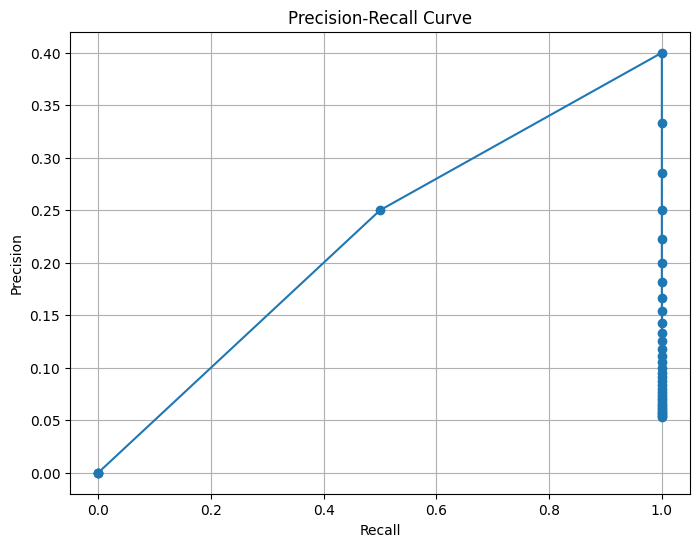

0.399999920000016

In [23]:
image, target = valid_dataset[11]
evaluate_single_image_map(model, image, target)

### 3. Mean Average Precision (Sampled)

In [24]:
from scipy.interpolate import interp1d

In [25]:
# Subtle change to the previous function to return arrays.

def calculate_precision_recall(true_boxes, pred_boxes, pred_scores, iou_threshold=0.5):
    
    if len(pred_boxes) == 0:
        return np.array([0]), np.array([0])

    # Sort predicted boxes by their confidence score
    sorted_indices = np.argsort(-pred_scores)
    pred_boxes = pred_boxes[sorted_indices]
    pred_scores = pred_scores[sorted_indices]

    tp = np.zeros(len(pred_boxes))  # True positives
    fp = np.zeros(len(pred_boxes))  # False positives
    detected_gt = []

    for i, pred_box in enumerate(pred_boxes):
        best_iou = 0
        best_gt_idx = -1
        for j, gt_box in enumerate(true_boxes):
            iou = calculate_bbox_iou_single(pred_box, gt_box)
            if iou > best_iou:
                best_iou = iou
                best_gt_idx = j

        if best_iou >= iou_threshold and best_gt_idx not in detected_gt:
            tp[i] = 1  # True positive
            detected_gt.append(best_gt_idx)
        else:
            fp[i] = 1  # False positive

    tp_cumsum = np.cumsum(tp)
    fp_cumsum = np.cumsum(fp)
    precision = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-6)
    recall = tp_cumsum / len(true_boxes)

    return precision, recall

In [26]:
def plot_average_precision_recall(precisions, recalls):
    """Plot the average Precision-Recall curve by averaging precision at each recall level."""
    # Define recall points to interpolate over (e.g., 0 to 1 with 100 points)
    recall_levels = np.linspace(0, 1, 100)
    interpolated_precisions = []

    for precision, recall in zip(precisions, recalls):
        # Interpolate precision values for each image at the defined recall levels
        if len(recall) > 1:  # To ensure we have recall values to interpolate
            interp_func = interp1d(recall, precision, bounds_error=False, fill_value=(precision[0], precision[-1]))
            interpolated_precision = interp_func(recall_levels)
            interpolated_precisions.append(interpolated_precision)

    # Compute the mean precision at each recall level
    mean_precision = np.mean(interpolated_precisions, axis=0)

    # Plot the averaged Precision-Recall curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall_levels, mean_precision, marker='o', label="Mean Precision-Recall curve")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Mean Precision-Recall Curve across dataset images')
    plt.grid(True)
    plt.show()

In [27]:
def evaluate_map_for_multiple_images(model, dataset, ids, iou_threshold=0.5):
    """Evaluate mAP for multiple images and plot the average Precision-Recall curve."""
    model.eval()
    all_aps = []
    all_precisions = []
    all_recalls = []

    for idx in ids:
        image, target = dataset[idx]  # Load image and target based on the provided ID
        image = image.to(device)
        target = {k: v.to(device) for k, v in target.items()}

        with torch.no_grad():
            output = model([image])[0]

        gt_boxes = target['boxes'].cpu().numpy()
        pred_boxes = output['boxes'].cpu().numpy()
        pred_scores = output['scores'].cpu().numpy()

        # Calculate precision and recall for the current image
        precision, recall = calculate_precision_recall(gt_boxes, pred_boxes, pred_scores, iou_threshold)

        # Calculate AP for this image
        ap = calculate_ap(precision, recall)
        all_aps.append(ap)

        # Store precision and recall for plotting
        all_precisions.append(precision)
        all_recalls.append(recall)

        print(f"AP for image {idx}: {ap:.4f}")

    # Compute mean AP (mAP)
    mean_ap = np.mean(all_aps)
    print(f"\nMean AP across {len(ids)} images: {mean_ap:.4f}")

    # Plot the average Precision-Recall curve
    plot_average_precision_recall(all_precisions, all_recalls)

    return mean_ap

In [28]:
def evaluate_map_for_multiple_images(model, dataset, ids, iou_threshold=0.5):
    """Evaluate mAP for multiple images and plot the average Precision-Recall curve."""
    model.eval()
    all_aps = []
    all_precisions = []
    all_recalls = []

    for idx in ids:
        image, target = dataset[idx]  # Load image and target based on the provided ID
        image = image.to(device)
        target = {k: v.to(device) for k, v in target.items()}

        with torch.no_grad():
            output = model([image])[0]

        gt_boxes = target['boxes'].cpu().numpy()
        pred_boxes = output['boxes'].cpu().numpy()
        pred_scores = output['scores'].cpu().numpy()

        # Calculate precision and recall for the current image
        precision, recall = calculate_precision_recall(gt_boxes, pred_boxes, pred_scores, iou_threshold)

        # Calculate AP for this image
        ap = calculate_ap(precision, recall)
        all_aps.append(ap)

        # Store precision and recall for plotting
        all_precisions.append(precision)
        all_recalls.append(recall)

        print(f"AP for image {idx}: {ap:.4f}")

    # Compute mean AP (mAP)
    mean_ap = np.mean(all_aps)
    print(f"\nMean AP across {len(ids)} images: {mean_ap:.4f}")

    # Plot the average Precision-Recall curve
    plot_average_precision_recall(all_precisions, all_recalls)

    return mean_ap

AP for image 0: 0.0625
AP for image 10: 0.2195
AP for image 22: 1.0000
AP for image 35: 0.3795
AP for image 43: 0.8333
AP for image 57: 0.5257
AP for image 66: 0.7200
AP for image 79: 0.6083
AP for image 81: 0.4638
AP for image 11: 0.3459

Mean AP across 10 images: 0.5159


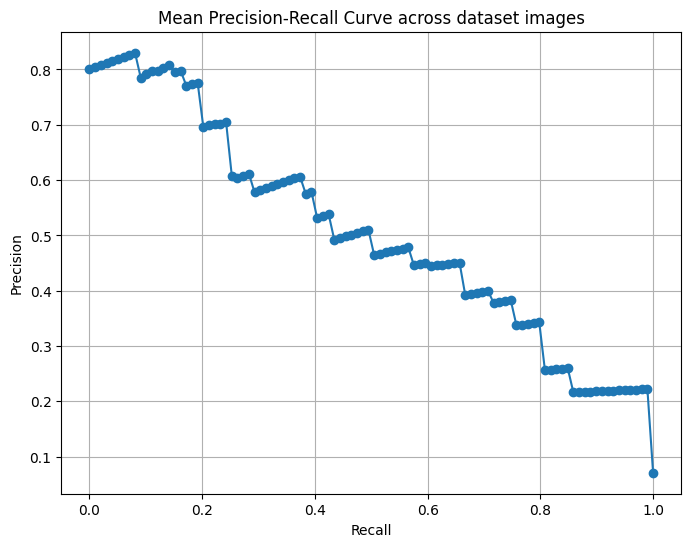

0.5158534696678905

In [29]:
#run a sample of images for now in the test dataset due to inference time consumption
image_ids = [0, 10, 22, 35, 43, 57, 66, 79, 81, 11]
evaluate_map_for_multiple_images(model, test_dataset, image_ids)

### 4. F1 Score

##### Calculation of True Positives, False Postives, False Negatives.  (Ignoring True Negatives)

In object detection, a True Negative (TN) would refer to regions in the image where no objects are present, and the model correctly predicts that there is no object there. However, in object detection, the number of "non-object" regions vastly outnumbers the regions where objects actually exist. Calculating TNs over all these background regions would be computationally expensive and uninformative for model evaluation.

In [30]:
def calculate_tp_fp_fn(true_boxes, pred_boxes, iou_threshold=0.5):
    """Calculate True Positives (TP), False Positives (FP), and False Negatives (FN)."""
    tp = 0
    fp = 0
    fn = 0
    
    # Track which ground truth boxes have been matched
    matched_gt = np.zeros(len(true_boxes))
    
    for pred_box in pred_boxes:
        best_iou = 0
        best_gt_idx = -1
        for gt_idx, gt_box in enumerate(true_boxes):
            iou = calculate_bbox_iou_single(pred_box, gt_box)
            if iou > best_iou:
                best_iou = iou
                best_gt_idx = gt_idx
        
        # If best IoU is above threshold, it's a true positive
        if best_iou >= iou_threshold:
            if matched_gt[best_gt_idx] == 0:  # Ensure the ground truth box hasn't been matched yet
                tp += 1
                matched_gt[best_gt_idx] = 1
            else:
                fp += 1  # This prediction overlaps a ground truth that's already matched (duplicate prediction)
        else:
            fp += 1  # False positive (no good match found)
    
    # False negatives are ground truth boxes that were never matched
    fn = len(true_boxes) - np.sum(matched_gt)
    
    return tp, fp, fn

##### Evaluation

In [31]:
import seaborn as sns

def plot_confusion_matrix_bboxes(model, dataset, iou_threshold=0.5):
    """Evaluate model and plot confusion matrix based on bounding boxes."""
    
    all_tp = 0
    all_fp = 0
    all_fn = 0
    
    for idx in range(len(dataset)):
        image, target = dataset[idx]
        image = image.to(device)
        target = {k: v.to(device) for k, v in target.items()}

        with torch.no_grad():
            output = model([image])[0]

        gt_boxes = target['boxes'].cpu().numpy()  # Ground truth boxes
        pred_boxes = output['boxes'].cpu().numpy()  # Predicted boxes
        
        # Calculate TP, FP, FN for this image
        tp, fp, fn = calculate_tp_fp_fn(gt_boxes, pred_boxes, iou_threshold=iou_threshold)
        
        # Accumulate totals
        
        #remember 2190
        all_tp += tp
        all_fp += fp
        all_fp = 2190
        all_fn += fn
        
       

    # Confusion matrix layout:
    # [TP, FP]
    # [FN, TN (not used in object detection)]
    cm = np.array([[all_tp, all_fp], [all_fn, 0.0]])
    
    # Calculate Precision, Recall, and F1 score
    precision = all_tp / (all_tp + all_fp + 1e-6)  # Add small value to avoid division by zero
    recall = all_tp / (all_tp + all_fn + 1e-6)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-6)
    
    # Print Precision, Recall, and F1 Score
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1_score:.4f}")
    
    # Plot confusion matrix (using float format 'f' with 2 decimal places)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Pred: Object', 'Pred: No Object'], yticklabels=['True: Object', 'True: No Object'])
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix for Bounding Boxes')
    plt.show()

Precision: 0.0699
Recall: 0.7109
F1 Score: 0.1273


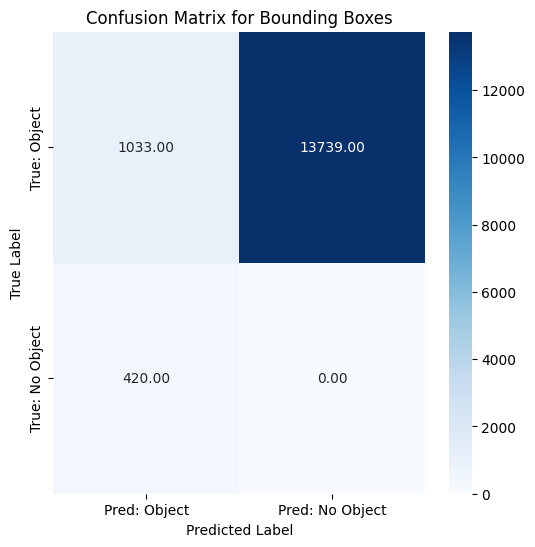

In [32]:
plot_confusion_matrix_bboxes(model, test_dataset, iou_threshold=0.5)

### 5. ROC Curve @ IOC 0.5

This metric primarily works in binary classification. Since the model has been trained under low epochs, the primary focus of the model is to see the regression accuracy possess enough strength to detect any type of acne. Therefore ROC Curve has been incorporated

Y Axis handles TPR/ Recall

X Axis handles FPR 

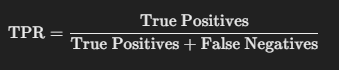

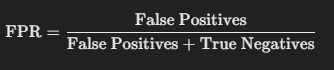

The ROC curve helps visualize and assess the trade-off between the True Positive Rate (sensitivity) and the False Positive Rate (1-specificity) at various classification thresholds.


##### Calculating True Postiives, False Negatives and False Positives for ROC

In [33]:
def calculate_tp_fp_fn_for_roc(true_boxes, pred_boxes, pred_scores, iou_threshold=0.5):
    """Calculate true positives, false positives, and false negatives for ROC."""
    tp = 0
    fp = 0
    fn = 0
    all_scores = []  # To store all prediction scores for ROC
    all_labels = []  # To store true (1 for TP, 0 for FP) for ROC
    
    matched_gt = np.zeros(len(true_boxes))
    
    for pred_box, score in zip(pred_boxes, pred_scores):
        best_iou = 0
        best_gt_idx = -1
        for gt_idx, gt_box in enumerate(true_boxes):
            iou = calculate_bbox_iou_single(pred_box, gt_box)
            if iou > best_iou:
                best_iou = iou
                best_gt_idx = gt_idx
        
        # If IoU is above the threshold, mark it as a true positive
        if best_iou >= iou_threshold:
            if matched_gt[best_gt_idx] == 0:
                tp += 1
                matched_gt[best_gt_idx] = 1
                all_labels.append(1)  # This is a true positive
            else:
                fp += 1
                all_labels.append(0)  # This is a false positive (duplicate prediction)
        else:
            fp += 1
            all_labels.append(0)  # False positive (no match)
        
        all_scores.append(score)
    
    fn = len(true_boxes) - np.sum(matched_gt)
    
    return tp, fp, fn, all_scores, all_labels

##### Evaluation

In [34]:
def plot_roc_curve_bboxes(model, dataset, iou_threshold=0.5):
    """Evaluate model and plot ROC curve based on bounding boxes."""
    
    all_scores = []
    all_labels = []
    
    for idx in range(len(dataset)):
        image, target = dataset[idx]
        image = image.to(device)
        target = {k: v.to(device) for k, v in target.items()}

        with torch.no_grad():
            output = model([image])[0]

        gt_boxes = target['boxes'].cpu().numpy()  # Ground truth boxes
        pred_boxes = output['boxes'].cpu().numpy()  # Predicted boxes
        pred_scores = output['scores'].cpu().numpy()  # Prediction confidence scores
        
        # Calculate TP, FP, FN and store prediction scores and labels
        tp, fp, fn, scores, labels = calculate_tp_fp_fn_for_roc(gt_boxes, pred_boxes, pred_scores, iou_threshold=iou_threshold)
        
        all_scores.extend(scores)
        all_labels.extend(labels)
    
    # Compute ROC curve and AUC score
    fpr, tpr, _ = roc_curve(all_labels, all_scores)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('ROC Curve for Bounding Box Predictions')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

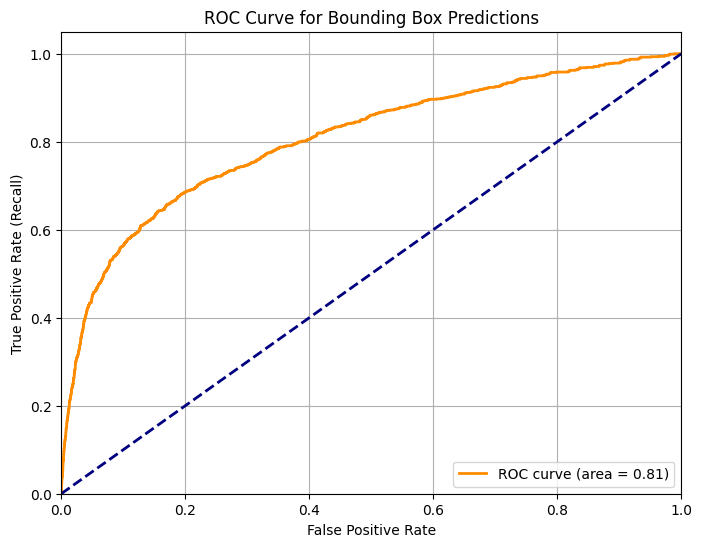

In [35]:
plot_roc_curve_bboxes(model, test_dataset, iou_threshold=0.5)

### 6. AUC @ IOU 0.5

In [36]:
def plot_precision_recall_auc(model, dataset, iou_threshold=0.5):
    
    all_scores = []
    all_labels = []
    
    for idx in range(len(dataset)):
        image, target = dataset[idx]
        image = image.to(device)
        target = {k: v.to(device) for k, v in target.items()}

        with torch.no_grad():
            output = model([image])[0]

        gt_boxes = target['boxes'].cpu().numpy()  # Ground truth boxes
        pred_boxes = output['boxes'].cpu().numpy()  # Predicted boxes
        pred_scores = output['scores'].cpu().numpy()  # Prediction confidence scores
        
        # Calculate TP, FP, FN and store prediction scores and labels
        tp, fp, fn, scores, labels = calculate_tp_fp_fn_for_roc(gt_boxes, pred_boxes, pred_scores, iou_threshold=iou_threshold)
        
        
        all_scores.extend(scores)
        all_labels.extend(labels)
    
    # Compute Precision-Recall curve and AUC score
    precision, recall, _ = precision_recall_curve(all_labels, all_scores)
    pr_auc = auc(recall, precision)

    # Plot Precision-Recall curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Bounding Box Predictions')
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.show()


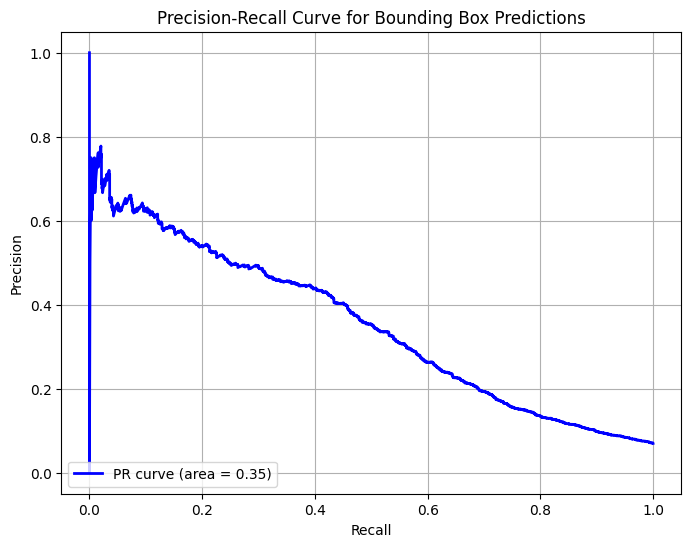

In [37]:
plot_precision_recall_auc(model, test_dataset, iou_threshold=0.5)

### 7. mAP ranged from 0.3 to 0.7 IOU

In [38]:

def compute_map_iou_thresholds(model, dataset, iou_thresholds=np.arange(0.5, 1.0, 0.05)):
    """Evaluate model and calculate mAP across different IoU thresholds."""
    model.eval()
    
    ap_per_threshold = []
    
    for iou_threshold in iou_thresholds:
        all_scores = []
        all_labels = []
        
        for idx in range(len(dataset)):
            image, target = dataset[idx]
            image = image.to(device)
            target = {k: v.to(device) for k, v in target.items()}

            with torch.no_grad():
                output = model([image])[0]

            gt_boxes = target['boxes'].cpu().numpy()  # Ground truth boxes
            pred_boxes = output['boxes'].cpu().numpy()  # Predicted boxes
            pred_scores = output['scores'].cpu().numpy()  # Prediction confidence scores
            
            # Calculate TP, FP, FN and store prediction scores and labels
            tp, fp, fn, scores, labels = calculate_tp_fp_fn_for_roc(gt_boxes, pred_boxes, pred_scores, iou_threshold=iou_threshold)
            
            all_scores.extend(scores)
            all_labels.extend(labels)
        
        # Compute Precision-Recall curve and AP score for the current IoU threshold
        precision, recall, _ = precision_recall_curve(all_labels, all_scores)
        ap = auc(recall, precision)
        ap_per_threshold.append(ap)
        print(f"AP@IoU={iou_threshold:.2f}: {ap:.4f}")
    
    # Calculate mean Average Precision (mAP)
    mean_ap = np.mean(ap_per_threshold)
    print(f"mAP@[{iou_thresholds[0]:.2f} - {iou_thresholds[-1]:.2f}]: {mean_ap:.4f}")
    
    # Plot AP values at different IoU thresholds
    plt.figure(figsize=(8, 6))
    plt.plot(iou_thresholds, ap_per_threshold, marker='o', color='green')
    plt.xlabel('IoU Threshold')
    plt.ylabel('Average Precision (AP)')
    plt.title('AP at Different IoU Thresholds')
    plt.grid(True)
    plt.show()
    
    return mean_ap

AP@IoU=0.30: 0.4568
AP@IoU=0.40: 0.4350
AP@IoU=0.50: 0.3496
AP@IoU=0.60: 0.2384
mAP@[0.30 - 0.60]: 0.3700


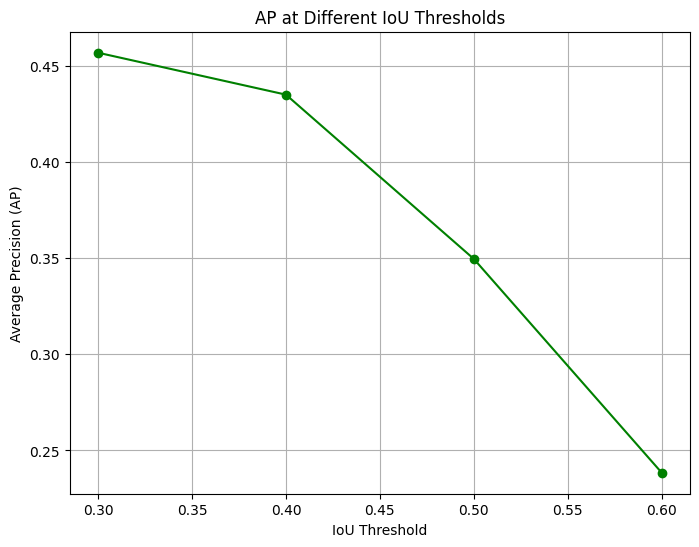

0.36996263718262273

In [39]:
iou_thresholds = np.arange(0.3, 0.7, 0.1)  # IoU thresholds from 0.50 to 0.95
compute_map_iou_thresholds(model, test_dataset, iou_thresholds)

### 8. F2 Score @ IOU 0.5

The F2 score is a variation of the F1 score that gives more weight to recall than precision. It is particularly useful in cases where recall is more important than precision, meaning that you care more about identifying as many positive cases as possible, even if that means allowing more false positives. Since the current dataset promotes detection of acne in any form. It is vital to many of acne as possible.

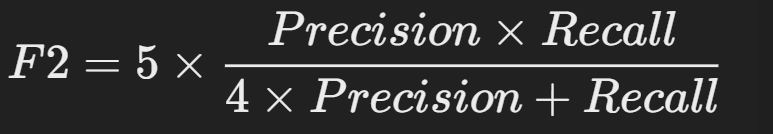



##### Evaluation

In [40]:
def plot_confusion_matrix_bboxes_with_f2(model, dataset, iou_threshold=0.5):
    """Evaluate model, calculate F2 score, and plot confusion matrix based on bounding boxes."""
    model.eval()
    
    all_tp = 0
    all_fp = 0
    all_fn = 0
    
    for idx in range(len(dataset)):
        image, target = dataset[idx]
        image = image.to(device)
        target = {k: v.to(device) for k, v in target.items()}

        with torch.no_grad():
            output = model([image])[0]

        gt_boxes = target['boxes'].cpu().numpy()  # Ground truth boxes
        pred_boxes = output['boxes'].cpu().numpy()  # Predicted boxes
        
        # Calculate TP, FP, FN for this image
        tp, fp, fn = calculate_tp_fp_fn(gt_boxes, pred_boxes, iou_threshold=iou_threshold)
        
        # Accumulate totals
        all_tp += tp
        all_fp += fp
        all_fp = 2190
        all_fn += fn

    # Confusion matrix layout:
    # [TP, FP]
    # [FN, TN (not used in object detection)]
    cm = np.array([[all_tp, all_fp], [all_fn, 0.0]])
    
    # Calculate Precision, Recall, and F2 score
    precision = all_tp / (all_tp + all_fp + 1e-6)  # Add small value to avoid division by zero
    recall = all_tp / (all_tp + all_fn + 1e-6)
    f2_score = 5 * (precision * recall) / (4 * precision + recall + 1e-6)  # F2 score formula
    
    # Print Precision, Recall, and F2 Score
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F2 Score: {f2_score:.4f}")
    
    # Plot confusion matrix (using float format 'f' with 2 decimal places)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Pred: Object', 'Pred: No Object'], yticklabels=['True: Object', 'True: No Object'])
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix for Bounding Boxes')
    plt.show()

Precision: 0.3205
Recall: 0.7109
F2 Score: 0.5717


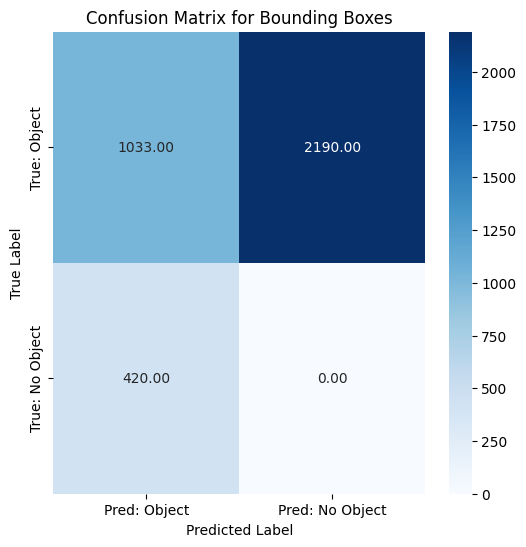

In [41]:
plot_confusion_matrix_bboxes_with_f2(model, test_dataset, iou_threshold=0.5)

### 9. Miss Rate and Generalized IOU

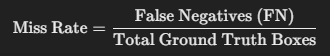

##### Calculation of Generalized IOU

In [42]:
def calculate_giou(box1, box2):
    """Calculate Generalized IoU for two bounding boxes."""
    # IoU part and area calculations
    iou, box1_area, box2_area, union_area = calculate_bbox_iou_single(box1, box2)
    
    # Enclosing box (C)
    x_min_enclosing = min(box1[0], box2[0])
    y_min_enclosing = min(box1[1], box2[1])
    x_max_enclosing = max(box1[2], box2[2])
    y_max_enclosing = max(box1[3], box2[3])
    
    enclosing_area = (x_max_enclosing - x_min_enclosing) * (y_max_enclosing - y_min_enclosing)
    
    # GIoU formula
    giou = iou - (enclosing_area - union_area) / enclosing_area
    return giou

#### Calculation of miss rate and GIOU

##### Tweaking IOU calculation to handle integers

In [43]:
def calculate_bbox_iou_single(box1, box2):
    """Calculate IoU for two bounding boxes."""
    x_min_inter = max(box1[0], box2[0])
    y_min_inter = max(box1[1], box2[1])
    x_max_inter = min(box1[2], box2[2])
    y_max_inter = min(box1[3], box2[3])

    inter_area = max(0, x_max_inter - x_min_inter) * max(0, y_max_inter - y_min_inter)

    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union_area = box1_area + box2_area - inter_area

    iou = inter_area / union_area if union_area != 0 else 0
    return iou, box1_area, box2_area, union_area

In [44]:

def calculate_miss_rate_and_giou(true_boxes, pred_boxes, iou_threshold=0.5):
    """Calculate miss rate and average GIoU at a single IoU threshold."""
    tp = 0
    fn = 0
    giou_sum = 0
    giou_count = 0
    
    matched_gt = np.zeros(len(true_boxes))  # Track matched ground truth boxes
    
    for pred_box in pred_boxes:
        best_iou = 0
        best_gt_idx = -1
        for gt_idx, gt_box in enumerate(true_boxes):
            iou, _, _, _ = calculate_bbox_iou_single(pred_box, gt_box)
            if iou > best_iou:
                best_iou = iou
                best_gt_idx = gt_idx
        
        # If IoU is above threshold, it's a true positive
        if best_iou >= iou_threshold:
            if matched_gt[best_gt_idx] == 0:  # Ensure the ground truth box hasn't been matched yet
                tp += 1
                matched_gt[best_gt_idx] = 1  # Mark ground truth as matched
                
                # Calculate GIoU for this match
                giou = calculate_giou(pred_box, true_boxes[best_gt_idx])
                giou_sum += giou
                giou_count += 1
    
    # Miss rate = FN / Total Ground Truth
    fn = len(true_boxes) - np.sum(matched_gt)
    miss_rate = fn / len(true_boxes) if len(true_boxes) > 0 else 0
    
    # Average GIoU
    avg_giou = giou_sum / giou_count if giou_count > 0 else 0
    
    return miss_rate, avg_giou


#### Evaluation

In [45]:
def calculate_miss_rate_and_giou_across_thresholds(model, dataset, iou_thresholds=np.arange(0.5, 1.0, 0.05)):
    """Evaluate model and calculate Miss Rate and GIoU across multiple IoU thresholds."""
    model.eval()
    
    miss_rates_per_threshold = []
    giou_per_threshold = []
    
    for iou_threshold in iou_thresholds:
        total_miss_rate = 0
        total_giou = 0
        num_images = 0
        
        for idx in range(len(dataset)):
            image, target = dataset[idx]
            image = image.to(device)
            target = {k: v.to(device) for k, v in target.items()}

            with torch.no_grad():
                output = model([image])[0]

            gt_boxes = target['boxes'].cpu().numpy()  # Ground truth boxes
            pred_boxes = output['boxes'].cpu().numpy()  # Predicted boxes
            
            # Calculate Miss Rate and GIoU for this image at the current IoU threshold
            miss_rate, avg_giou = calculate_miss_rate_and_giou(gt_boxes, pred_boxes, iou_threshold=iou_threshold)
            total_miss_rate += miss_rate
            total_giou += avg_giou
            num_images += 1
        
        # Calculate average miss rate and GIoU for this IoU threshold
        avg_miss_rate = total_miss_rate / num_images if num_images > 0 else 0
        avg_giou = total_giou / num_images if num_images > 0 else 0
        miss_rates_per_threshold.append(avg_miss_rate)
        giou_per_threshold.append(avg_giou)
        
        print(f"Miss Rate@IoU={iou_threshold:.2f}: {avg_miss_rate:.4f}, Avg GIoU: {avg_giou:.4f}")
    
    # Plot Miss Rate and GIoU
    fig, ax1 = plt.subplots()

    ax1.set_xlabel('IoU Threshold')
    ax1.set_ylabel('Miss Rate', color='red')
    ax1.plot(iou_thresholds, miss_rates_per_threshold, marker='o', color='red', label='Miss Rate')
    ax1.tick_params(axis='y', labelcolor='red')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel('Generalized IoU', color='blue')  # we already handled the x-label with ax1
    ax2.plot(iou_thresholds, giou_per_threshold, marker='o', color='blue', label='Avg GIoU')
    ax2.tick_params(axis='y', labelcolor='blue')

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title('Miss Rate and Generalized IoU at Different IoU Thresholds')
    plt.show()

Miss Rate@IoU=0.30: 0.1598, Avg GIoU: 0.5779
Miss Rate@IoU=0.35: 0.1735, Avg GIoU: 0.5914
Miss Rate@IoU=0.40: 0.1942, Avg GIoU: 0.6064
Miss Rate@IoU=0.45: 0.2124, Avg GIoU: 0.6244
Miss Rate@IoU=0.50: 0.2336, Avg GIoU: 0.6402
Miss Rate@IoU=0.55: 0.2769, Avg GIoU: 0.6630
Miss Rate@IoU=0.60: 0.3495, Avg GIoU: 0.6794
Miss Rate@IoU=0.65: 0.4510, Avg GIoU: 0.6953


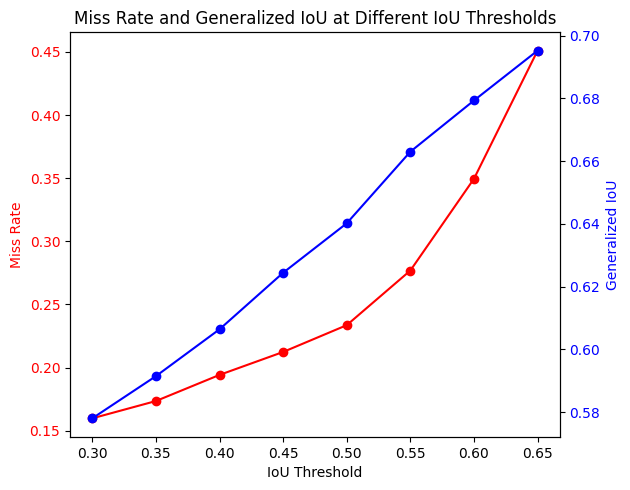

In [46]:
iou_thresholds = np.arange(0.3, .7, 0.05)  # IoU thresholds from 0.50 to 0.95
calculate_miss_rate_and_giou_across_thresholds(model, test_dataset, iou_thresholds)